In [ ]:
import innvestigate
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

# Wczytujemy dane

In [ ]:
tr_data = np.load('/content/drive/MyDrive/WarsztatyBadawcze/images.npy')
tr_data = np.expand_dims(tr_data, axis=3)
tr_data = tr_data / 255.

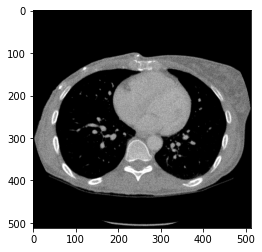

In [ ]:
plt.imshow(tr_data[0, :, :].reshape((512, 512)), cmap='gray')
plt.show()

In [ ]:
from PIL import Image

img = Image.fromarray(tr_data[0, :, :].reshape((512, 512)))

In [ ]:
from __future__ import division

from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.utils.vis_utils import plot_model as plot
from keras.optimizers import SGD
from keras.layers import *
import numpy as np


def BCDU_net_D3_inn(input_size=(512, 512, 1), weights=None):
    N = input_size[0]
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    # D1
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4_1 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4_1 = Dropout(0.5)(conv4_1)
    # D2
    conv4_2 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(drop4_1)
    conv4_2 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4_2)
    conv4_2 = Dropout(0.5)(conv4_2)
    # D3
    merge_dense = concatenate([conv4_2, drop4_1], axis=3)
    conv4_3 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge_dense)
    conv4_3 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4_3)
    drop4_3 = Dropout(0.5)(conv4_3)

    up6 = Conv2DTranspose(256, kernel_size=2, strides=2, padding='same', kernel_initializer='he_normal')(drop4_3)
    up6 = BatchNormalization(axis=3)(up6)
    up6 = Activation('relu')(up6)

    x1 = Reshape(target_shape=(1, np.int32(N / 4), np.int32(N / 4), 256))(drop3)
    x2 = Reshape(target_shape=(1, np.int32(N / 4), np.int32(N / 4), 256))(up6)
    merge6 = concatenate([x1, x2], axis=1)
    merge6 = ConvLSTM2D(filters=128, kernel_size=(3, 3), padding='same', return_sequences=False, go_backwards=True,
                        kernel_initializer='he_normal')(merge6)

    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2DTranspose(128, kernel_size=2, strides=2, padding='same', kernel_initializer='he_normal')(conv6)
    up7 = BatchNormalization(axis=3)(up7)
    up7 = Activation('relu')(up7)

    x1 = Reshape(target_shape=(1, np.int32(N / 2), np.int32(N / 2), 128))(conv2)
    x2 = Reshape(target_shape=(1, np.int32(N / 2), np.int32(N / 2), 128))(up7)
    merge7 = concatenate([x1, x2], axis=1)
    merge7 = ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', return_sequences=False, go_backwards=True,
                        kernel_initializer='he_normal')(merge7)

    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2DTranspose(64, kernel_size=2, strides=2, padding='same', kernel_initializer='he_normal')(conv7)
    up8 = BatchNormalization(axis=3)(up8)
    up8 = Activation('relu')(up8)

    x1 = Reshape(target_shape=(1, N, N, 64))(conv1)
    x2 = Reshape(target_shape=(1, N, N, 64))(up8)
    merge8 = concatenate([x1, x2], axis=1)
    merge8 = ConvLSTM2D(filters=32, kernel_size=(3, 3), padding='same', return_sequences=False, go_backwards=True,
                        kernel_initializer='he_normal')(merge8)

    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    conv8 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    conv9 = Conv2D(1, 1, activation='sigmoid')(conv8)

    model = Model(inputs=inputs, outputs=conv9)
    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    if weights is not None:
      model.load_weights(weights)
    return model

In [ ]:
model = BCDU_net_D3_inn(weights='/content/drive/MyDrive/WarsztatyBadawcze/wagi.h5')

/usr/local/lib/python3.7/dist-packages/innvestigate/analyzer/base.py:110: UserWarning: LRP is only tested for convolutional neural networks.
Check triggerd by layers: [<keras.layers.convolutional_recurrent.ConvLSTM2D object at 0x7faceef9e990>, <keras.layers.convolutional_recurrent.ConvLSTM2D object at 0x7faceeb2ae10>, <keras.layers.convolutional_recurrent.ConvLSTM2D object at 0x7facee6b7bd0>]
  warnings.warn(tmp_message)


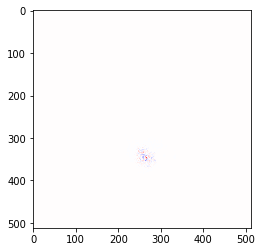

In [ ]:
analyzer = innvestigate.analyzer.LRPEpsilon(model)
analysis = analyzer.analyze(sample.reshape((1, 512, 512, 1)))
plt.imshow(analysis.squeeze(), cmap='seismic')
plt.show()

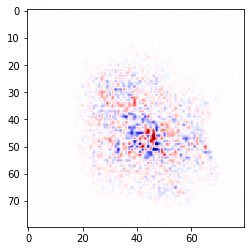

In [ ]:
plt.imshow(analysis[:, 300:380, 220:300].squeeze(), cmap='seismic')
plt.show()

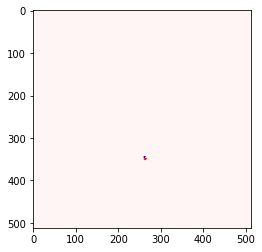

In [ ]:
analyzer2 = innvestigate.analyzer.DeepTaylor(model)
analysis2 = analyzer2.analyze(sample.reshape((1, 512, 512, 1)))
plt.imshow(analysis2.squeeze(), cmap='seismic')
plt.show()

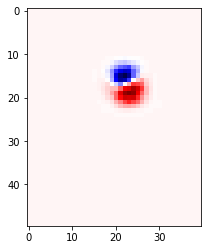

In [ ]:
plt.imshow(analysis2[:, 330:380, 240:280].squeeze(), cmap='seismic')
plt.show()

/usr/local/lib/python3.7/dist-packages/innvestigate/analyzer/base.py:110: UserWarning: LRP is only tested for convolutional neural networks.
Check triggerd by layers: [<keras.layers.convolutional_recurrent.ConvLSTM2D object at 0x7faceef9e990>, <keras.layers.convolutional_recurrent.ConvLSTM2D object at 0x7faceeb2ae10>, <keras.layers.convolutional_recurrent.ConvLSTM2D object at 0x7facee6b7bd0>]
  warnings.warn(tmp_message)


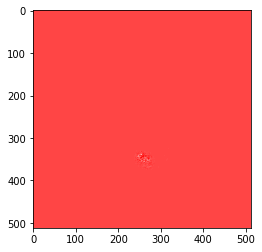

In [ ]:
analyzer3 = innvestigate.analyzer.LRPEpsilonIgnoreBias(model)
analysis3 = analyzer3.analyze(sample.reshape((1, 512, 512, 1)))
plt.imshow(analysis3.squeeze(), cmap='seismic')
plt.show()

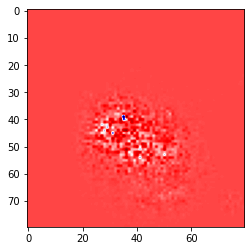

In [ ]:
plt.imshow(analysis3[:, 300:380, 220:300].squeeze(), cmap='seismic')
plt.show()